# TripAdvisor Recommendation Challenge
In this project, we will build a recommendation system based on *TripAdvisor* reviews. Our goal is to implement a BM25 baseline and a custom recommendation model that can outperform BM25 using user reviews only, without access to explicit ratings during the recommendation phase.

In [1]:
!pip install rank_bm25

In [2]:
import pandas as pd # For data management
import json # For manipulating JSON-like formatted strings/documents
import numpy as np # To use "argsort" function
from rank_bm25 import BM25Okapi # For BM25 implementation
from collections import Counter # For counting occurrences of elements, used here for word frequency analysis
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Display progress bar
from tqdm import tqdm

# ==== scikit-learn ====
from sklearn.metrics import root_mean_squared_error, ndcg_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ==== NLTK for NLP ====
import nltk

# For tokenizing text based on a regular expression pattern
nltk.download('punkt')
from nltk.tokenize import regexp_tokenize

# For accessing stopwords, which are commonly removed from text data
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# For converting words to their base form (lemmatization)
nltk.download("wordnet") # lemmatizer
from nltk.stem import WordNetLemmatizer

c:\Users\Joyce\anaconda3\envs\ml-nlp\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joyce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joyce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joyce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# PROJECT_PATH = "/content/drive/MyDrive/Ecole/ESILV/A5/Machine Learning for NLP/Project/"
PROJECT_PATH = ""

## Data Loading and Preprocessing
We will load the TripAdvisor dataset (downloadable from Kaggle), filter it based on specified aspects, and preprocess by concatenating reviews by place (`offering_id`).

### Loading the dataset

In [4]:
# Load dataset
df = pd.read_csv(PROJECT_PATH + 'data/reviews.csv')
df.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


In [5]:
df.shape

(878561, 10)

In [6]:
df.dtypes

ratings              object
title                object
text                 object
author               object
date_stayed          object
offering_id           int64
num_helpful_votes     int64
date                 object
id                    int64
via_mobile             bool
dtype: object

In [7]:
df.isnull().sum()

ratings                  0
title                    0
text                     0
author                   0
date_stayed          67594
offering_id              0
num_helpful_votes        0
date                     0
id                       0
via_mobile               0
dtype: int64

### Filtering reviews with specific aspects

In [8]:
# Filter reviews with specific aspects
required_aspects = ['service', 'cleanliness', 'overall', 'value', 'location', 'sleep_quality', 'rooms']

# Filter rows where all required aspects are in each 'ratings' entry
df = df[df["ratings"].apply(lambda x: all(aspect in x for aspect in required_aspects))]

print(f"New DataFrame's shape: {df.shape}")
df.head()

New DataFrame's shape: (436391, 10)


,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


We went from **878,561** rows to **436,391 rows**; so about 450k rows didn't contain all the aspects we need to compare all places accurately.

### Concatenating reviews from the same place

In [9]:
# Function to calculate average rating for each aspect
def get_avg_rating_aspects(ratings_str):
    # Convert each string in the list to a dictionary
    ratings_dicts = [json.loads(rating.replace("'", "\"")) for rating in ratings_str]

    # Get the number of ratings to calculate the average
    nb_ratings = len(ratings_dicts)

    # Initialize a dictionary to store average ratings per aspect
    avg_ratings = {}

    # Iterate over each required aspect
    for aspect in required_aspects:
        # Initialize the sum for the current aspect
        aspect_rating_sum = 0

        # Sum up the ratings for the current aspect from all dictionaries
        for ratings in ratings_dicts:
            aspect_rating_sum += ratings[aspect]

        # Calculate the average rating for the aspect, rounded to 1 decimal place
        avg_ratings[aspect] = round(aspect_rating_sum / nb_ratings, 1)

    # Return the dictionary with average ratings for each aspect
    return avg_ratings

In [10]:
# Call custom aggregate function on "ratings" column
df_grouped = df.groupby('offering_id').agg({'text': '\n'.join, 'ratings': get_avg_rating_aspects}).reset_index()

# Rename the 'text' column to be more explicit
df_grouped.rename(columns={"text": "reviews"}, inplace=True)

print(f"Grouped DataFrame's shape: {df_grouped.shape}")
df_grouped.head()

Grouped DataFrame's shape: (3754, 3)


,offering_id,reviews,ratings
0,72572,I had to make fast visit to seattle and I foun...,"{'service': 4.6, 'cleanliness': 4.6, 'overall'..."
1,72579,"Great service, rooms were clean, could use som...","{'service': 4.2, 'cleanliness': 4.2, 'overall'..."
2,72586,Beautiful views of the space needle - especial...,"{'service': 4.2, 'cleanliness': 4.3, 'overall'..."
3,72598,This hotel is in need of some serious updates....,"{'service': 3.2, 'cleanliness': 3.2, 'overall'..."
4,73236,My experience at this days inn was perfect. th...,"{'service': 4.3, 'cleanliness': 3.1, 'overall'..."


### Adding hotel info to `df`

*This step is merely to make the results more readable for us humans, so that instead of an ID we get an actual place name with some info (e.g., stars).*

In [11]:
# Load hotels' information
offerings = pd.read_csv(PROJECT_PATH + "data/offerings.csv")
offerings.head()

,hotel_class,region_id,url,phone,details,address,type,id,name
0,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '147 West 4...",hotel,113317,Casablanca Hotel Times Square
1,5.0,32655,http://www.tripadvisor.com/Hotel_Review-g32655...,NaN,NaN,"{'region': 'CA', 'street-address': '300 S Dohe...",hotel,76049,Four Seasons Hotel Los Angeles at Beverly Hills
2,3.5,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '790 Eighth...",hotel,99352,Hilton Garden Inn Times Square
3,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '152 West 5...",hotel,93589,The Michelangelo Hotel
4,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '130 West 4...",hotel,217616,The Muse Hotel New York


In [12]:
# Drop useless columns
offerings.drop(columns=["region_id", "url", "phone", "details", "address", "type"], inplace=True)
offerings.head(1)

,hotel_class,id,name
0,4.0,113317,Casablanca Hotel Times Square


*Might remove `hotel_class` later if it turns out to be useless...*

In [13]:
offerings.isnull().sum()

hotel_class    1192
id                0
name              0
dtype: int64

Let's store these null rows to check if the replacement has been done correctly when the time comes.

In [14]:
idx_null_class = offerings[offerings["hotel_class"].isnull()].index
offerings.iloc[idx_null_class]

,hotel_class,id,name
6,NaN,2643161,The NoMad Hotel
44,NaN,1630591,Crowne Plaza
49,NaN,585164,Residence Inn Houston West/Energy Corridor
52,NaN,258634,Scottish Inn & Suites Reliant Park/Six Flags
70,NaN,815515,Scottish Inns & Suites - Willowbrook
...,...,...,...
4253,NaN,1204691,Quality Inn & Suites Laurel
4259,NaN,1218625,Wyndham
4261,NaN,1515599,Executive Apartments
4262,NaN,84068,Harrington Hotel


A hotel with a missing value in regards to its class basically means that the hotel has **0 stars**, so we can replace these `NaN` values with `0`.

In [15]:
offerings["hotel_class"] = offerings["hotel_class"].fillna(0)
offerings.iloc[idx_null_class]

,hotel_class,id,name
6,0.0,2643161,The NoMad Hotel
44,0.0,1630591,Crowne Plaza
49,0.0,585164,Residence Inn Houston West/Energy Corridor
52,0.0,258634,Scottish Inn & Suites Reliant Park/Six Flags
70,0.0,815515,Scottish Inns & Suites - Willowbrook
...,...,...,...
4253,0.0,1204691,Quality Inn & Suites Laurel
4259,0.0,1218625,Wyndham
4261,0.0,1515599,Executive Apartments
4262,0.0,84068,Harrington Hotel


The replacement has been done successfully; so now we can **merge** both of the DataFrames.

In [16]:
# Rename "id" column for the merge to go through
offerings.rename(columns={"id": "offering_id"}, inplace=True)

# Merge both DataFrames on "offering_id" column
final_df = df_grouped.merge(offerings, on="offering_id")

# Re-order the columns in a more logical order
final_df = final_df.iloc[:, [0, 4, 3, 2, 1]]
final_df

,offering_id,name,hotel_class,ratings,reviews
0,72572,BEST WESTERN PLUS Pioneer Square Hotel,3.5,"{'service': 4.6, 'cleanliness': 4.6, 'overall'...",I had to make fast visit to seattle and I foun...
1,72579,BEST WESTERN Loyal Inn,2.0,"{'service': 4.2, 'cleanliness': 4.2, 'overall'...","Great service, rooms were clean, could use som..."
2,72586,BEST WESTERN PLUS Executive Inn,3.0,"{'service': 4.2, 'cleanliness': 4.3, 'overall'...",Beautiful views of the space needle - especial...
3,72598,Comfort Inn & Suites Seattle,2.5,"{'service': 3.2, 'cleanliness': 3.2, 'overall'...",This hotel is in need of some serious updates....
4,73236,Days Inn San Antonio/Near Lackland AFB,2.0,"{'service': 4.3, 'cleanliness': 3.1, 'overall'...",My experience at this days inn was perfect. th...
...,...,...,...,...,...
3749,3523356,Hampton Inn & Suites Austin @ The University/C...,2.5,"{'service': 4.9, 'cleanliness': 4.9, 'overall'...",I've stayed at plenty of Hampton Inns during m...
3750,3541823,New York Budget Inn,0.0,"{'service': 4.3, 'cleanliness': 4.5, 'overall'...","Inn staff absolutely wonderful, helpful, knowl..."
3751,3572384,Hyatt Place Chicago/River North,0.0,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...","Crowded, noisy, dirty. Service is poor, food i..."
3752,3572583,Holiday Inn Express New York - Manhattan West ...,3.0,"{'service': 1.0, 'cleanliness': 1.0, 'overall'...",El hotel estaba en medio de una remodelación. ...


## Implementing BM25 Baseline
Using the [`rank_bm25`](github.com/dorianbrown/rank_bm25) library to implement a BM25 model. We will retrieve the most similar place for a given query based on BM25 scores.

### Preprocessing

In [17]:
# Preprocess function to clean and prepare text
def preprocess(text, count=False):
    stop_words = set(stopwords.words("english"))

    # Tokenization
    tokens = regexp_tokenize(text.lower(), r"\w+")
    tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return Counter(tokens) if count else tokens  # Returning tokens directly for use in BM25

#### Showing the occurrences of each token.

In [18]:
preprocess(final_df["reviews"][2], True)

Counter({'hotel': 267,
         'room': 230,
         'needle': 129,
         'seattle': 125,
         'space': 124,
         'staff': 123,
         'great': 104,
         'breakfast': 88,
         'location': 86,
         'clean': 78,
         'good': 77,
         'stay': 77,
         'night': 74,
         'u': 70,
         'best': 69,
         'view': 66,
         'nice': 61,
         'monorail': 61,
         'would': 59,
         'western': 55,
         'one': 55,
         'place': 54,
         'parking': 53,
         'walk': 53,
         'downtown': 51,
         'service': 50,
         'desk': 48,
         'friendly': 48,
         'time': 46,
         'restaurant': 46,
         'center': 45,
         'stayed': 45,
         'price': 45,
         'day': 44,
         'bed': 44,
         'also': 44,
         'front': 43,
         'helpful': 43,
         'well': 38,
         'like': 36,
         'buffet': 36,
         'block': 34,
         'area': 34,
         'free': 33,
         'get'

#### Getting only tokens.

In [19]:
preprocess(final_df["reviews"][2])

['beautiful',
 'view',
 'space',
 'needle',
 'especially',
 'night',
 'like',
 'photography',
 'ask',
 'room',
 'view',
 'staff',
 'great',
 'local',
 'restuarant',
 'excellent',
 'secure',
 'parking',
 'plus',
 'free',
 'wi',
 'fi',
 'issue',
 'waking',
 'conference',
 'call',
 'could',
 'find',
 'internet',
 'password',
 'called',
 'front',
 'desk',
 'man',
 'duty',
 'would',
 'give',
 'insisited',
 'come',
 'get',
 'person',
 'tried',
 'convince',
 'dressed',
 'claimed',
 'policy',
 'guest',
 'come',
 'collect',
 'password',
 'desk',
 'got',
 'dressed',
 'went',
 'downstairs',
 'get',
 'ridiculous',
 'seriously',
 'irritated',
 'anyway',
 'spoke',
 'day',
 'staff',
 'seemed',
 'shocked',
 'hotel',
 'policy',
 'keep',
 'code',
 'safe',
 'intending',
 'see',
 'king',
 'tutankhamen',
 'treasure',
 'pacific',
 'science',
 'center',
 'leaf',
 'january',
 'time',
 'getting',
 'short',
 'decided',
 'better',
 'purchase',
 'vip',
 'ticket',
 'go',
 'specific',
 'time',
 'stand',
 'line',
 '

#### Application on all reviews

Now we can apply the preprocessing to all the reviews to make our **corpus**.

In [20]:
# Prepare corpus
corpus = [preprocess(doc) for doc in final_df['reviews']]

# Show five first elements of corpus
corpus[:5]

[['make',
  'fast',
  'visit',
  'seattle',
  'found',
  'pioneer',
  'regret',
  'hotel',
  'comfortable',
  'clean',
  'else',
  'mm',
  'nice',
  'area',
  'everything',
  'walking',
  'distance',
  'guess',
  'breakfast',
  'something',
  'else',
  'bread',
  'waffle',
  'fourth',
  'fifth',
  'time',
  'staying',
  'best',
  'western',
  'pioneer',
  'square',
  'like',
  'location',
  'within',
  'walking',
  'distance',
  'downtown',
  'waterfront',
  'ball',
  'field',
  'get',
  'town',
  'park',
  'available',
  'garage',
  'rest',
  'trip',
  'foot',
  'minute',
  'walk',
  'action',
  'downtown',
  'pike',
  'street',
  'shopping',
  'etc',
  'may',
  'far',
  'walk',
  'like',
  'dealing',
  'driving',
  'parking',
  'downtown',
  'place',
  'nothing',
  'fancy',
  'hotel',
  'room',
  'nice',
  'clean',
  'staff',
  'helpful',
  'friendly',
  'view',
  'room',
  'also',
  'leave',
  'much',
  'desired',
  'fact',
  'better',
  'worrying',
  'gazing',
  'window',
  'place'

### Implementation

In [21]:
# Initialize BM25
bm25 = BM25Okapi(corpus)

In [22]:
# Define function to retrieve most similar place
def retrieve_bm25(query, k=1):
    query = preprocess(query)
    scores = bm25.get_scores(query)

    # Returns the indices of scores sorted in descending order & selects the top k indices corresponding to the highest scores.
    top_k_idx = np.argsort(scores)[::-1][:k]

    return final_df.iloc[top_k_idx][['offering_id', 'name', 'hotel_class', 'ratings', 'reviews']]

### Best hotel for different queries according to the ***BM25 model***

In [23]:
# Example usage
query_service = 'excellent service and clean rooms'
retrieve_bm25(query_service)

,offering_id,name,hotel_class,ratings,reviews
2612,258705,Hotel Commonwealth,4.0,"{'service': 4.8, 'cleanliness': 4.9, 'overall'...",I was pleasantly surprised that this hotel was...


In [24]:
query_food = 'delicious food and great view'
retrieve_bm25(query_food)

,offering_id,name,hotel_class,ratings,reviews
166,79868,Bay Club Hotel & Marina,3.0,"{'service': 4.6, 'cleanliness': 4.5, 'overall'...",Great hopitality and a wonderful location. The...


## Custom Recommendation Model
Here, we will experiment with different methods to improve on BM25. We'll start with TF-IDF and progress to embedding-based models using `sentence-transformers`. Finally, we may re-rank using a similarity metric to find the best match.

### TF-IDF-Based Custom Model

Using **TF-IDF (Term Frequency - Inverse Document Frequency)**, we can create vector representations for each place's concatenated reviews. Then, we’ll compare a query with these vectors using cosine similarity.

In [25]:
# Instantiate TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform reviews into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(final_df['reviews'])  # 'reviews' column with concatenated reviews per place

In [26]:
def retrieve_tfidf(query, k=5):
    # Transform the query text into TF-IDF vector
    query_vec = tfidf_vectorizer.transform([query])

    # Compute cosine similarity between the query vector and all document vectors
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get the indices of the top-k most similar places
    top_k_idx = scores.argsort()[::-1][:k]

    # Return the top-k places based on similarity
    return final_df.iloc[top_k_idx][['offering_id', 'name', 'hotel_class', 'ratings', 'reviews']]

#### Top 5 hotels for different queries according to the ***TF-IDF model***

In [27]:
retrieve_tfidf(query_service)

,offering_id,name,hotel_class,ratings,reviews
1091,98940,Houston Inn and Suites,0.0,"{'service': 3.0, 'cleanliness': 3.0, 'overall'...","I stay for a weekend, and the rooms were nice ..."
2570,249793,BEST WESTERN Fort Worth Inn & Suites,3.0,"{'service': 4.7, 'cleanliness': 4.8, 'overall'...",I was very impressed when as I was walking in ...
1531,109101,La Quinta Inn & Suites Fort Worth North,2.5,"{'service': 4.4, 'cleanliness': 4.6, 'overall'...",Rolling into Fort Worth after a long day on th...
90,74845,Comfort Inn West,2.0,"{'service': 4.5, 'cleanliness': 4.5, 'overall'...",We had a wonderful stay!! Beautiful redone roo...
1973,124066,Ramada Limited Addison,0.0,"{'service': 4.0, 'cleanliness': 3.0, 'overall'...",Hotel based on a main road but within walking ...


In [28]:
retrieve_tfidf(query_food)

,offering_id,name,hotel_class,ratings,reviews
1645,112136,Penn's View Hotel,3.0,"{'service': 4.5, 'cleanliness': 4.6, 'overall'...",This hotel is located in the old city and is c...
603,87608,Holiday Inn Chicago - Mart Plaza,3.0,"{'service': 4.1, 'cleanliness': 4.3, 'overall'...","If your visiting Chicago, and are a little fle..."
1263,100567,The Edgewater Hotel Seattle,4.0,"{'service': 4.3, 'cleanliness': 4.3, 'overall'...",I have traveled to Seattle extremely often for...
602,87603,"Hotel 71, Wyndham Affiliate",3.5,"{'service': 4.4, 'cleanliness': 4.4, 'overall'...","Stayed there for 6 nights, Upon arrival shocke..."
703,89620,Hyatt Harborside at Boston's Logan Internation...,4.0,"{'service': 4.3, 'cleanliness': 4.5, 'overall'...",My boyfriend and I loved this hotel! Our room ...


### Embedding-Based Custom Model with Sentence Transformers

Using Sentence Transformers (like `all-MiniLM-L6-v2`), we can create dense embeddings of the review text, which generally capture semantic similarities better than TF-IDF.

In [29]:
# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each place's concatenated reviews
embeddings = model.encode(final_df['reviews'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

In [30]:
def retrieve_embeddings(query, k=5):
    # Encode the query into an embedding vector
    query_embedding = model.encode(query)

    # Compute cosine similarity between the query embedding and all document embeddings
    scores = cosine_similarity([query_embedding], embeddings).flatten()

    # Get indices of the top-k most similar places
    top_k_idx = np.argsort(scores)[::-1][:k]

    # Return the top-k most similar places
    return final_df.iloc[top_k_idx][['offering_id', 'name', 'hotel_class', 'ratings', 'reviews']]

#### Top 5 hotels for different queries according to the ***Embedding-Based Custom model***

In [31]:
retrieve_embeddings(query_service)

,offering_id,name,hotel_class,ratings,reviews
3301,1174784,Holiday Inn Baltimore-Towson,0.0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","Found the room exceptionally clean, the staff ..."
3086,656554,Charlotte Express Inn,2.0,"{'service': 3.5, 'cleanliness': 2.5, 'overall'...","Very courteous, helpful and professional staff..."
1818,119997,Belcaro Motel,0.0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","Perfectly clean. Some new bath renovations, bu..."
2823,497952,Americas Best Value Inn - San Antonio / Lackla...,2.0,"{'service': 2.8, 'cleanliness': 3.8, 'overall'...",Great clean rooms and great service.\nHotel wa...
2881,553345,Americas Best Value Inn & Suites Granada Hills,2.0,"{'service': 4.7, 'cleanliness': 4.4, 'overall'...","Rooms were clean,air conditioner worked well,t..."


In [32]:
retrieve_embeddings(query_food)

,offering_id,name,hotel_class,ratings,reviews
3723,2627745,Hotel Palomar Phoenix - a Kimpton Hotel,4.0,"{'service': 4.9, 'cleanliness': 4.9, 'overall'...",We are big fans of Kimpton Hotels and have sta...
2692,275455,Scottish Inn Memphis Airport,0.0,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",Very nice property located several long blocks...
3691,2151571,Hotel Americano,0.0,"{'service': 3.9, 'cleanliness': 4.4, 'overall'...",I have just come back from a 9 day trip from t...
1499,108980,Hampton Inn Austin - Arboretum Northwest,2.5,"{'service': 4.8, 'cleanliness': 4.7, 'overall'...",Everything about this hotel screams that they ...
1629,111751,Hotel Bel-Air,5.0,"{'service': 4.7, 'cleanliness': 4.9, 'overall'...",Beautiful & classic high class hotel. The spac...


### Re-Ranking Using Hybrid Approach

To combine the strengths of both models, we create a **hybrid model** where we:
1. Retrieve a larger set of similar places (e.g., top 10) using TF-IDF, and then
2. Re-rank these candidates with the embedding-based model.

In [33]:
def retrieve_hybrid(query, initial_k=10, final_k=5):
    # Step 1: Initial retrieval with TF-IDF or BM25 to get top-k candidates
    initial_candidates = retrieve_tfidf(query, k=initial_k)

    # Step 2: Generate embeddings for the initial candidates' reviews
    candidate_embeddings = model.encode(initial_candidates['reviews'].tolist())
    query_embedding = model.encode(query)

    # Step 3: Re-rank candidates based on embedding similarity
    scores = cosine_similarity([query_embedding], candidate_embeddings).flatten()
    top_k_idx = np.argsort(scores)[::-1][:final_k]

    # Return final top-k ranked places
    return initial_candidates.iloc[top_k_idx]

#### Top 5 hotels for different queries according to the ***Hybrid model***

In [34]:
retrieve_hybrid(query_service)

,offering_id,name,hotel_class,ratings,reviews
1091,98940,Houston Inn and Suites,0.0,"{'service': 3.0, 'cleanliness': 3.0, 'overall'...","I stay for a weekend, and the rooms were nice ..."
90,74845,Comfort Inn West,2.0,"{'service': 4.5, 'cleanliness': 4.5, 'overall'...",We had a wonderful stay!! Beautiful redone roo...
2178,223171,Super 8 Houston,2.0,"{'service': 4.4, 'cleanliness': 4.2, 'overall'...",The hotel was very neat and good for the price...
2570,249793,BEST WESTERN Fort Worth Inn & Suites,3.0,"{'service': 4.7, 'cleanliness': 4.8, 'overall'...",I was very impressed when as I was walking in ...
3625,1846923,Sleep Inn & Suites I-45 / Airtex,2.0,"{'service': 4.8, 'cleanliness': 4.8, 'overall'...",I stay in many Choice Hotels during the year. ...


In [35]:
retrieve_hybrid(query_food)

,offering_id,name,hotel_class,ratings,reviews
166,79868,Bay Club Hotel & Marina,3.0,"{'service': 4.6, 'cleanliness': 4.5, 'overall'...",Great hopitality and a wonderful location. The...
302,81126,"Mandarin Oriental, San Francisco",5.0,"{'service': 4.8, 'cleanliness': 4.9, 'overall'...",The sweeping views from the 40 th floor are ju...
2306,223983,Baltimore Marriott Waterfront,4.0,"{'service': 4.4, 'cleanliness': 4.6, 'overall'...",I had a reservation at a different hotel but a...
1234,100507,Inn at the Market,4.0,"{'service': 4.8, 'cleanliness': 4.9, 'overall'...",My cousin and I went to Seattle to attend the ...
1645,112136,Penn's View Hotel,3.0,"{'service': 4.5, 'cleanliness': 4.6, 'overall'...",This hotel is located in the old city and is c...


### Summary of Each Approach
- **TF-IDF**: Quick but mainly focuses on word overlap, which can miss out on semantic similarity.
- **Embedding-Based Model**: Captures semantic meaning and is more accurate but computationally heavier.
- **Hybrid Model**: Combines initial recall with TF-IDF followed by a fine-grained re-ranking using embeddings.

## Evaluation Metrics
For evaluation, we will use Mean Squared Error (MSE) to calculate the error between ratings on each aspect for the recommended and actual places.
This score will be calculated across both BM25 and custom models to compare performance.

In [36]:
# Calculate MSE for a single recommendation
def calculate_mse(actual_ratings, predicted_ratings):
    return root_mean_squared_error(actual_ratings, predicted_ratings)

In [37]:
# Define the sample size of query places for evaluation
sample_size = 100
samples     = final_df.sample(sample_size)
max_char    = 280 # Max limit of characters for query, like an X post

## Results and Analysis

### MSE scores for each model
We will run the BM25 and custom model to retrieve places for several test queries, then calculate the MSE for each model and compare the results.

In [ ]:
# Store MSE scores for each model
bm25_mse_scores = []
custom_mse_scores = []
custom_embedding_mse_scores = []
custom_hybrid_mse_scores = []

# Step 1: Loop over a sample of query places in the dataset
progress_bar = tqdm(samples.iterrows(), total=sample_size, desc="MSE Calculations")
for _, query_place in progress_bar:
    query_text = query_place['reviews'][:max_char]  # Use the concatenated reviews for the place as the query
    actual_ratings = query_place["ratings"]  # Actual ratings for MSE calculation

    # Step 2: Retrieve the most similar place using BM25
    bm25_recommendation = retrieve_bm25(query_text, k=1)
    bm25_predicted_ratings = bm25_recommendation["ratings"].iloc[0]

    # Calculate MSE for BM25
    bm25_mse = calculate_mse(list(actual_ratings.values()), list(bm25_predicted_ratings.values()))
    bm25_mse_scores.append(bm25_mse)

    # Step 3: Retrieve the most similar place using the Custom Model
    custom_recommendation = retrieve_tfidf(query_text, k=1)
    custom_predicted_ratings = custom_recommendation["ratings"].iloc[0]

    # Calculate MSE for the Custom Model
    custom_mse = calculate_mse(list(actual_ratings.values()), list(custom_predicted_ratings.values()))
    custom_mse_scores.append(custom_mse)

    # Step 4: Retrieve the most similar place using the Custom Model
    custom_embedding_recommendation = retrieve_embeddings(query_text, k=1)
    custom_embedding_predicted_ratings = custom_embedding_recommendation["ratings"].iloc[0]

    # Calculate MSE for the Custom Model
    custom_embedding_mse = calculate_mse(list(actual_ratings.values()), list(custom_embedding_predicted_ratings.values()))
    custom_embedding_mse_scores.append(custom_embedding_mse)

    # Step 5: Retrieve the most similar place using the Custom Model
    custom_hybrid_recommendation = retrieve_hybrid(query_text, final_k=1)
    custom_hybrid_predicted_ratings = custom_hybrid_recommendation["ratings"].iloc[0]

    # Calculate MSE for the Custom Model
    custom_hybrid_mse = calculate_mse(list(actual_ratings.values()), list(custom_hybrid_predicted_ratings.values()))
    custom_hybrid_mse_scores.append(custom_hybrid_mse)

# Step 6: Compute the average MSE across all queries for each model
avg_bm25_mse = sum(bm25_mse_scores) / len(bm25_mse_scores)
avg_custom_mse = sum(custom_mse_scores) / len(custom_mse_scores)
avg_custom_embedding_mse = sum(custom_embedding_mse_scores) / len(custom_embedding_mse_scores)
avg_custom_hybrid_mse = sum(custom_hybrid_mse_scores) / len(custom_hybrid_mse_scores)

print(f"Average BM25 MSE: {(avg_bm25_mse * 100):.2f}%")
print(f"Average Custom Model MSE: {(avg_custom_mse * 100):.2f}%")
print(f"Average Embedding Model MSE: {(avg_custom_embedding_mse * 100):.2f}%")
print(f"Average Hybrid Model MSE: {(avg_custom_hybrid_mse * 100):.2f}%")

In [39]:
print(f"Average BM25 MSE: {(avg_bm25_mse * 100):.2f}%")
print(f"Average Custom Model MSE: {(avg_custom_mse * 100):.2f}%")
print(f"Average Embedding Model MSE: {(avg_custom_embedding_mse * 100):.2f}%")
print(f"Average Hybrid Model MSE: {(avg_custom_hybrid_mse * 100):.2f}%")

Average BM25 MSE: 29.91%
Average Custom Model MSE: 31.34%
Average Embedding Model MSE: 29.76%
Average Hybrid Model MSE: 22.13%


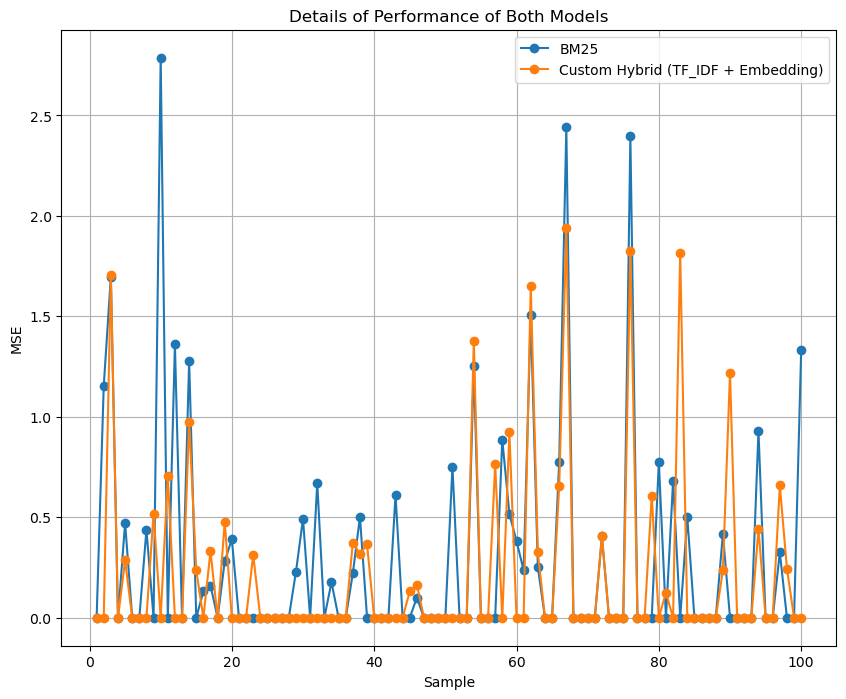

In [40]:
plt.figure(figsize=(10, 8))  # Set the figure size

plt.plot(range(1, sample_size + 1), bm25_mse_scores, marker='o', label=f'BM25')
# plt.plot(range(1, sample_size + 1), custom_mse_scores, label=f'Custom (TF-IDF)')
# plt.plot(range(1, sample_size + 1), custom_embedding_mse_scores, label=f'Custom Embedding')
plt.plot(range(1, sample_size + 1), custom_hybrid_mse_scores, marker='o', label=f'Custom Hybrid (TF_IDF + Embedding)')

# Set titles and labels
plt.title("Details of Performance of Both Models")
plt.xlabel("Sample")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

1. **Hybrid Model** (22.13% MSE):\
The Hybrid model, combining the initial ranking of TF-IDF with re-ranking by embeddings, performs best, with an 26.45% MSE. This likely indicates that embeddings add value when used to refine results within a more relevant subset, offering a good balance between term-based and semantic similarity.

2. **Embedding Model** (29.76% MSE):\
This model has a much higher MSE. This could happen if embeddings aren’t fine-tuned on similar hotel review data, making the model potentially less aligned with the dataset’s vocabulary or context.

3. **BM25 Model** (29.91% MSE):\
BM25 achieves a slightly higher MSE, likely due to its inability to consistently capture the full semantic similarity, despite its strong ability to retrieve similar documents based on term frequency and document frequency.

4. **Custom Model with TF-IDF** (31.34% MSE):\
TF-IDF relies on term frequency but might miss some contextual relevance, especially in cases where semantic meaning is important which might explain its poor performance compared to the other models.

It looks like the ***hybrid model*** is a strong candidate here, with room for further improvements to potentially outperform BM25 by an even wider margin.

### NDCG Scores for each models

In [41]:
# Store NDCG scores for each model
bm25_ndcg_scores = []
custom_ndcg_scores = []
custom_embedding_ndcg_scores = []
custom_hybrid_ndcg_scores = []

# Loop over a sample of query places in the dataset
for _, query_place in tqdm(samples.iterrows(), total=float(sample_size), desc="NDCG Calculations"):
    query_text = query_place['reviews'][:max_char]  # Use the concatenated reviews for the place as the query
    actual_ratings = query_place["ratings"]  # Actual ratings

    # Convert actual ratings to relevance scores and ensure it's a list
    actual_relevance = [list(actual_ratings.values())]

    # Step 1: Retrieve the most similar place using BM25
    bm25_recommendation = retrieve_bm25(query_text, k=1)
    bm25_predicted_ratings = bm25_recommendation["ratings"].iloc[0]
    bm25_relevance = [list(bm25_predicted_ratings.values())]

    # Calculate NDCG for BM25
    bm25_ndcg = ndcg_score(actual_relevance, bm25_relevance)
    bm25_ndcg_scores.append(bm25_ndcg)

    # Step 2: Retrieve the most similar place using the Custom Model (TF-IDF)
    custom_recommendation = retrieve_tfidf(query_text, k=1)
    custom_predicted_ratings = custom_recommendation["ratings"].iloc[0]
    custom_relevance = [list(custom_predicted_ratings.values())]

    # Calculate NDCG for the Custom Model
    custom_ndcg = ndcg_score(actual_relevance, custom_relevance)
    custom_ndcg_scores.append(custom_ndcg)

    # Step 3: Retrieve the most similar place using the Embedding Model
    custom_embedding_recommendation = retrieve_embeddings(query_text, k=1)
    custom_embedding_predicted_ratings = custom_embedding_recommendation["ratings"].iloc[0]
    custom_embedding_relevance = [list(custom_embedding_predicted_ratings.values())]

    # Calculate NDCG for the Embedding Model
    custom_embedding_ndcg = ndcg_score(actual_relevance, custom_embedding_relevance)
    custom_embedding_ndcg_scores.append(custom_embedding_ndcg)

    # Step 4: Retrieve the most similar place using the Hybrid Model
    custom_hybrid_recommendation = retrieve_hybrid(query_text, final_k=1)
    custom_hybrid_predicted_ratings = custom_hybrid_recommendation["ratings"].iloc[0]
    custom_hybrid_relevance = [list(custom_hybrid_predicted_ratings.values())]

    # Calculate NDCG for the Hybrid Model
    custom_hybrid_ndcg = ndcg_score(actual_relevance, custom_hybrid_relevance)
    custom_hybrid_ndcg_scores.append(custom_hybrid_ndcg)

# Compute the average NDCG across all queries for each model
avg_bm25_ndcg = np.mean(bm25_ndcg_scores)
avg_custom_ndcg = np.mean(custom_ndcg_scores)
avg_custom_embedding_ndcg = np.mean(custom_embedding_ndcg_scores)
avg_custom_hybrid_ndcg = np.mean(custom_hybrid_ndcg_scores)

# Print average NDCG results
print(f"Average BM25 NDCG: {avg_bm25_ndcg:.4f}")
print(f"Average Custom Model NDCG: {avg_custom_ndcg:.4f}")
print(f"Average Embedding Model NDCG: {avg_custom_embedding_ndcg:.4f}")
print(f"Average Hybrid Model NDCG: {avg_custom_hybrid_ndcg:.4f}")

NDCG Calculations: 100%|██████████| 100/100.0 [02:07<00:00,  1.28s/it]

Average BM25 NDCG: 0.9933
Average Custom Model NDCG: 0.9933
Average Embedding Model NDCG: 0.9917
Average Hybrid Model NDCG: 0.9949


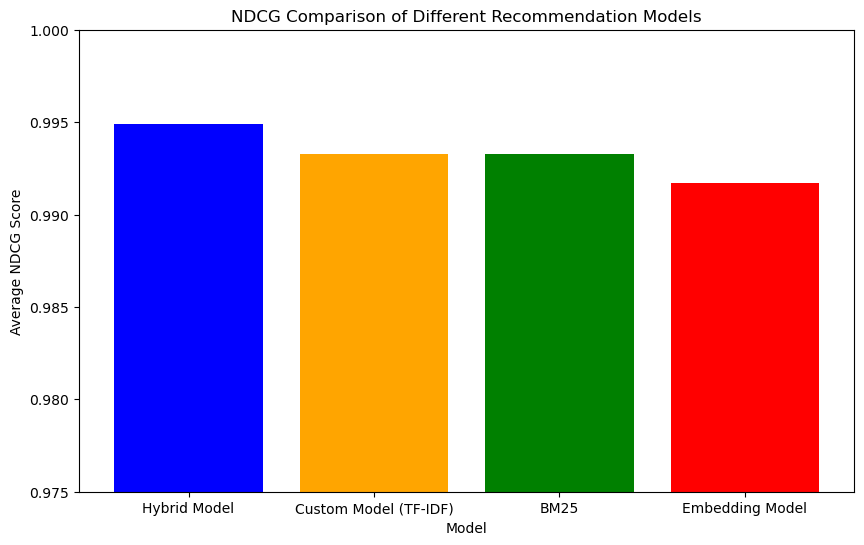

In [42]:
# Models for plots
models = ['BM25', 'Custom Model (TF-IDF)', 'Embedding Model', 'Hybrid Model']
ndcg_scores = [avg_bm25_ndcg, avg_custom_ndcg, avg_custom_embedding_ndcg, avg_custom_hybrid_ndcg]

# Sorting results for display
sorted_data = sorted(zip(models, ndcg_scores), key=lambda x: x[1], reverse=True)
sorted_models, sorted_scores = zip(*sorted_data)  # Unpack the sorted data

# Plots
plt.figure(figsize=(10, 6))
plt.bar(sorted_models, sorted_scores, color=['blue', 'orange', 'green', 'red'])
plt.title('NDCG Comparison of Different Recommendation Models')
plt.xlabel('Model')
plt.ylabel('Average NDCG Score')
plt.ylim(.975, 1)  # NDCG scores between 0.975 and 1
plt.show()